# Intro

7/26: The purpose of this notebook is to double check that we're calculating the surface terms correctly when we look at advective and diffusive tendencies. This will look at map view and TS view of the Barents Sea at the surface in one month (March) to see if we're doing this thing correctly.

# Load the files, set up grid

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import xarray as xr
import h5py
from scipy.io import loadmat
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm

import warnings
warnings.filterwarnings("ignore")


# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from calc_UV_conv_1face import calc_UV_conv_1face
from calc_mskmean_T_mod import calc_mskmean_T_mod
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.
from binning import *                    # bin_array, create_mesh
from plotting_helpers import *           # truncate_colormap

In [2]:
%run /home/mmurakami/crios_backups/ASTE_270/prep_grid.py

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



In [3]:
RAC3d = np.tile(RAC[np.newaxis,:,:],(nz,1,1))
RAC3d.shape

(50, 1350, 270)

In [4]:
path = "/home/mmurakami/crios_backups/ASTE_270/offline_binning/sample_images/"

In [5]:
klev = 0

In [6]:

# read one basin or whole ASTE
whole = False
if not whole:
    iB = 6    # example read from BarentsSea
    
# mymsk below defines as all Arctic down to Fram Strait and BSO but not GINs Seas
mymsk = mskBasin.copy()

# Create a boolean mask for elements that are 6 or less
# mask = mymsk <7
whole = True
if whole:
    mask = (mymsk < 5) | (mymsk==6) 
else:
    mask = mymsk == 6

# Set elements that are greater than 6 to np.nan
mymsk[mask] = 1
mymsk[~mask] = np.nan

test = get_aste_tracer(mymsk,nfx,nfy)[0]
test[:,:270] = np.nan
mymsk = test

mymsk = aste_tracer2compact(mymsk,nfx,nfy)[0]

# Get the number of points where mskBasin is 6 or less
npoints = np.count_nonzero(mymsk)  # Count the number of True values in the mask
print(npoints)

364500


In [7]:
# create an array of the time steps we want to read
# use ts2dte to get december 2014
# first make an array of filenames
dt = 600 # for the MODEL, not for tendency calculations
startyr = 2002
endyr = 2019

m = 0
s = 2

# all the filenames in the system
fnames = get_fnames(dt,startyr,endyr)

times = {}
# times["2014"] = np.array([1,2,3,4,5,6,7,8,9,10,11,12])
times["2014"] = np.array([3,4])     # tend will be calculated from tsteps before and after one month

# try a different month to see
# times["2014"] = np.array([9,10])     # tend will be calculated from tsteps before and after one month


# the filenames we want for 2014
tsstr,datetimes = get_tsteps(times,fnames,dt,startyr,1,1)

# ocean and ice
AB_gT=0
AB_gS=0
debug = False
ffac = 1

dt = np.array([])
for i in range(1,len(datetimes)):
    dt = np.append(dt,(datetimes[i]-datetimes[i-1]).total_seconds())

### note -- these are thetadr and saltdr but are called theta and salt, dthetadt and dsaltdt

In [8]:
# note: the following works provided that the first 3 terms are definitely there
file_name = "state_3d_set1"
meta_budg2d_zflux_set2 = parsemeta(dirState + file_name + "." + tsstr[1] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set2["fldList"])
varnames = np.array(["THETA","SALT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
THETA,its,meta = rdmds(os.path.join(dirState, file_name),int(tsstr[1]),returnmeta=True,rec=recs[0])
SALT,its,meta = rdmds(os.path.join(dirState, file_name),int(tsstr[1]),returnmeta=True,rec=recs[1])

In [9]:
THETA = THETA.reshape(nz,ny,nx)
SALT = SALT.reshape(nz,ny,nx)

In [10]:
# note: the following works provided that the first 3 terms are definitely there
file_name = "state_2d_set1"
meta_budg2d_zflux_set2 = parsemeta(dirState + file_name + "." + tsstr[1] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set2["fldList"])
varnames = np.array(["SIheff","SIarea"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
SIheff,its,meta = rdmds(os.path.join(dirState, file_name),int(tsstr[1]),returnmeta=True,rec=recs[0])
SIarea,its,meta = rdmds(os.path.join(dirState, file_name),int(tsstr[1]),returnmeta=True,rec=recs[1])

SIheff = SIheff.reshape(ny,nx)
SIarea = SIarea.reshape(ny,nx)

In [11]:
file_name = "budg2d_zflux_set2"
meta_budg2d_zflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[1] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set2["fldList"])
varnames = np.array(["oceQnet","WTHMASS","SIaaflux"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
oceQnet,its,meta = rdmds(os.path.join(dirIn, file_name),int(tsstr[1]),returnmeta=True,rec=recs[0])
WTHMASS,its,meta = rdmds(os.path.join(dirIn, file_name),int(tsstr[1]),returnmeta=True,rec=recs[1])
SIaaflux,its,meta = rdmds(os.path.join(dirIn, file_name),int(tsstr[1]),returnmeta=True,rec=recs[2])

oceQnet = oceQnet.reshape((ny,nx))
WTHMASS = WTHMASS.reshape((ny,nx))
SIaaflux = SIaaflux.reshape((ny,nx))

In [12]:
file_name = 'budg3d_snap_set2'
THETADR = read_field3d(tsstr,nz,ny,nx,file_name,np.array(["THETADR"]),mymsk,dirIn)
SALTDR = read_field3d(tsstr,nz,ny,nx,file_name,np.array(["SALTDR"]),mymsk,dirIn)

# divide first two and second two by dt
theta = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
dthetadt = np.full((int(len(tsstr)-1),nz,ny,nx),np.nan)
salt = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
dsaltdt = np.full((int(len(tsstr)-1),nz,ny,nx),np.nan)

thetadr = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
dthetadrdt = np.full((int(len(tsstr)-1),nz,ny,nx),np.nan)
saltdr = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
dsaltdrdt = np.full((int(len(tsstr)-1),nz,ny,nx),np.nan)

for i in range(len(tsstr)):
    # with dividing out hFacC grid
    theta[i,:,:,:] = THETADR[i,:,:,:]/mygrid['hFacC']/DRF3d
    salt[i,:,:,:]  = SALTDR[i,:,:,:]/mygrid['hFacC']/DRF3d

    # without dividing out hFacC grid
    thetadr[i,:,:,:] = THETADR[i,:,:,:]  #/mygrid['hFacC']
    saltdr[i,:,:,:]  = SALTDR[i,:,:,:]  #/mygrid['hFacC']

for i in range(len(tsstr)-1):
    dthetadt[i,:,:,:] = (THETADR[i,:,:,:]/DRF3d/mygrid['hFacC'] - THETADR[i-1,:,:,:]/DRF3d/mygrid['hFacC'])/dt[i-1]
    dsaltdt[i,:,:,:] = (SALTDR[i,:,:,:]/DRF3d/mygrid['hFacC'] - SALTDR[i-1,:,:,:]/DRF3d/mygrid['hFacC'])/dt[i-1]

    # keeping the weights in the function
    dthetadrdt[i,:,:,:] = (THETADR[i,:,:,:] - THETADR[i-1,:,:,:])/dt[i-1]
    dsaltdrdt[i,:,:,:] = (SALTDR[i,:,:,:] - SALTDR[i-1,:,:,:])/dt[i-1]

In [13]:
# for mass tendency (m^3/s) - time is not yet included in this block
file_name = 'budg2d_snap_set1'

# assuming all files are structured the same
meta_budg2d_snap_set1 = parsemeta(dirIn + file_name + "." + tsstr[0]+ ".meta")
# try to read this with rec
fldlist = np.array(meta_budg2d_snap_set1['fldList'])
varnames = np.array(['ETAN'])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

# set for all months
vol = np.zeros((len(tsstr),nz, ny, nx))
print("volume allocation shape",vol.shape)

for t in range(len(tsstr)):
    t1 = tsstr[t]
    read = [int(t1)]

    # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
    ETAN,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[0])

    # choose by basin
    ETAN = np.reshape(ETAN,(ny,nx))

    # ocean
    if debug:
        print(read,its[0],its[1]) # these iteration numbers should be the same as read

    # 3D, with rStar:
    tmpvol = np.zeros((nz, ny, nx))
    if myparms['useNLFS'] < 2 or myparms['rStar'] == 0:        # not this time
        tmpvol[0,:, :] = ETAN * myparms['rhoconst'] * RAC
        if myparms['useRFWF'] == 0:
            tmpvol[0, :, :] = np.zeros((ny, nx))
    else:    # 4/22 look at this one
        if myparms['useRFWF'] != 0:                                 # we are using this  # check if tmp1 is the same as drf3d!!
            tmp1 = mk3D_mod(mygrid['DRF'],hfC) * hfC     # m
            tmp2 = tmp1/mk3D_mod(DD,tmp1)                # drf as a fraction of total depth, this allows us to distribute etan between z
        else:
            tmp2 = drf3d / mk3D_mod(DD, tmp1)

        # this is still wrong, we want to subtract the ETAN anomaly from the existing volumes
        tmpvol =  (tmp1 + tmp2*mk3D_mod(ETAN, tmp2)) * mk3D_mod(RAC, hfC) * ffac     # volume, m * m^2  = m^3

    vol[t,:,:,:] = tmpvol * np.tile(mymsk, (nz, 1, 1))

print(vol.shape)

volume allocation shape (2, 50, 1350, 270)
(2, 50, 1350, 270)


In [14]:
# first have to get the vector values from U and V
file_name = "budg3d_hflux_set2"
# UVELMASS = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['UVELMASS']),mymsk,dirIn)
# VVELMASS = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['VVELMASS']),mymsk,dirIn)
ADVx_TH = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['ADVx_TH']),mymsk,dirIn)     # degC m^3/s
ADVy_TH = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['ADVy_TH']),mymsk,dirIn)
DFxE_TH = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['DFxE_TH']),mymsk,dirIn)
DFyE_TH = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['DFyE_TH']),mymsk,dirIn)
ADVx_SLT = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['ADVx_SLT']),mymsk,dirIn)   # PSU m^3/s
ADVy_SLT = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['ADVy_SLT']),mymsk,dirIn)
DFxE_SLT = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['DFxE_SLT']),mymsk,dirIn)
DFyE_SLT = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['DFyE_SLT']),mymsk,dirIn)

In [15]:
file_name = "budg3d_zflux_set2"
ADVr_SLT = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['ADVr_SLT']),mymsk,dirIn)
ADVr_TH = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['ADVr_TH']),mymsk,dirIn)
DFrE_SLT = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['DFrE_SLT']),mymsk,dirIn)
DFrE_TH = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['DFrE_TH']),mymsk,dirIn)
DFrI_SLT = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['DFrI_SLT']),mymsk,dirIn)
DFrI_TH = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['DFrI_TH']),mymsk,dirIn)

In [16]:
file_name = "budg3d_kpptend_set1"
KPPg_TH = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['KPPg_TH']),mymsk,dirIn)
KPPg_SLT = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['KPPg_SLT']),mymsk,dirIn)
oceSPtnd = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['oceSPtnd']),mymsk,dirIn)

In [17]:
# load the surface heat - to transform we / by rcp [J/(m^3*degC)] and * by RAC [m^2] = degC.m^3/s
file_name = 'budg2d_zflux_set1'
TFLUX = read_field2d(tsstr,ny,nx,file_name,np.array(['TFLUX']),mymsk,dirIn)            # W/m^2
SItflux = read_field2d(tsstr,ny,nx,file_name,np.array(['SItflux']),mymsk,dirIn)        # W/m^2
oceQsw = read_field2d(tsstr,ny,nx,file_name,np.array(['oceQsw']),mymsk,dirIn)          # W/m^2
SPforcT1=0*np.ones((ny,nx))
TRELAX = np.zeros((ny,nx))
geothFlux = 0

# load the surface terms for salt - to transform we / by rho [m^3/s] and * by RAC [m^2] = PSU.m^3/s
file_name = 'budg2d_zflux_set1'
SFLUX = read_field2d(tsstr,ny,nx,file_name,np.array(['SFLUX']),mymsk,dirIn)            # g/m^2/s
oceSPflx = read_field2d(tsstr,ny,nx,file_name,np.array(['oceSPflx']),mymsk,dirIn)      # g/m^2/s
file_name = 'budg2d_zflux_set2'
oceSflux = read_field2d(tsstr,ny,nx,file_name,np.array(['oceSflux']),mymsk,dirIn)      # g/m^2/s 
WSLTMASS = read_field2d(tsstr,ny,nx,file_name,np.array(['WSLTMASS']),mymsk,dirIn)      # PSU.m/s

In [18]:
# SFLUX[1][y,x]

In [19]:
tsstr

array(['0000639648', '0000644112'], dtype='<U32')

# Create the TS bins

In [20]:
# try new T bins where different sizes
refined_section = np.linspace(-3,8,93)
coarse_section = np.linspace(8,15,21,endpoint=False)
binsTH_edges = np.concatenate((refined_section,coarse_section[1:]))
binsTH_centers = (binsTH_edges[:-1] + binsTH_edges[1:])/2
nT = binsTH_edges.shape[0]-1

# do bi-sectional form for S
coarse_section = np.linspace(0, 28, 30, endpoint=False)
refined_section = np.linspace(28, 40, 83)
binsSLT_edges = np.concatenate((coarse_section, refined_section))
binsSLT_centers = (binsSLT_edges[:-1] + binsSLT_edges[1:])/2
nS = binsSLT_edges.shape[0]-1

Tbin,Sbin = np.meshgrid(binsTH_edges,binsSLT_edges)
Tbincent,Sbincent = np.meshgrid(binsTH_centers,binsSLT_centers)

binwidthT = binsTH_edges[1:] - binsTH_edges[:-1]
binwidthS = binsSLT_edges[1:] - binsSLT_edges[:-1]
dT,dS = np.meshgrid(binwidthT,binwidthS)
dT = dT.reshape(112,112,1)
dS = dS.reshape(112,112,1)


# create the binned values for theta and salt
# we want to bin theta and salt into the T and S bins
binned_theta = bin_array(theta,binsTH_edges)
binned_theta = binned_theta.astype(float)
binned_theta[binned_theta == nT] = np.nan     # because the binning is setting nan to last value
binned_salinity = bin_array(salt,binsSLT_edges)
binned_salinity = binned_salinity.astype(float)
binned_salinity[binned_salinity == nS] = np.nan

In [21]:
# df_distr_attr_th = distr_attr_th.copy()
# df_distr_attr_slt = distr_attr_slt.copy()

In [22]:
# do salt tendency
# Initialize the new array with the desired shape (2, z, y, x)
dSALTDRdt = np.zeros((1, SALTDR.shape[1], SALTDR.shape[2], SALTDR.shape[3]))
# Calculate the differences and assign to the new array
dSALTDRdt[0] = (SALTDR[1] - SALTDR[0]) / (datetimes[1]-datetimes[0]).total_seconds()
# dSALTDRdt[1] = (SALTDR[3] - SALTDR[2])  / (datetimes[3]-datetimes[2]).total_seconds()
print(dSALTDRdt.shape)    # PSU.m  / s

# now calculate the tendency for the two months times[0], times[2]
AB_gS = 0
G_S = np.zeros((1, SALTDR.shape[1], SALTDR.shape[2], SALTDR.shape[3]))
for i in range(dSALTDRdt.shape[0]):
    G_S[i] = (dSALTDRdt[i] - AB_gS) * mk3D_mod(RAC,dSALTDRdt[i])   # PSU.m/s * m^2 = PSU.m^3/s

(1, 50, 1350, 270)


In [24]:
# do heat tendency
# Initialize the new array with the desired shape (2, z, y, x)
dTHETADRdt = np.zeros((1, THETADR.shape[1], THETADR.shape[2], THETADR.shape[3]))
# Calculate the differences and assign to the new array
dTHETADRdt[0] = (THETADR[1] - THETADR[0]) / (datetimes[1]-datetimes[0]).total_seconds()
# dTHETADRdt[1] = (THETADR[3] - THETADR[2]) / (datetimes[3]-datetimes[2]).total_seconds()
print(dTHETADRdt.shape)    # degC.m / s

# now calculate the tendency for the two months times[0], times[2]
G_T = np.zeros((1, THETADR.shape[1], THETADR.shape[2], THETADR.shape[3]))
for i in range(dTHETADRdt.shape[0]):
    G_T[i] = (dTHETADRdt[i]-AB_gT)*mk3D_mod(RAC,dTHETADRdt[i])     # degC.m/s * m^2 = degC.m^3/s

(1, 50, 1350, 270)


# Do T convergence for one cell - this is what An will advise

# also pick a z cell!!!

In [25]:
# mygrid['hFacC'][21,y,x]

In [142]:
# check a point in the center of the map
y = 500
x = 25
z = 0

# at the egde of face 3
# y = 500
# x = 0

# at the edge of face 1
# y = 449
# x = 170

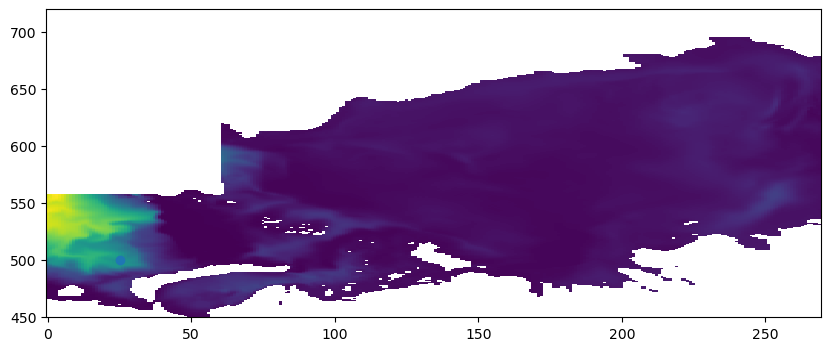

In [144]:
# plot for face 3
XV,YV = np.meshgrid(np.arange(0,270,1),np.arange(450,720,1))
plt.pcolormesh(XV,YV,theta[1][2][450:720,:270])
plt.plot(x,y,'o')

In [145]:
# # plot for face 1
# XV,YV = np.meshgrid(np.arange(0,450,1),np.arange(0,270,1))
# # plt.pcolormesh(XV,YV,theta[1][0][450:720,:270])
# plt.pcolormesh(theta[1][0][:450,:270])
# plt.plot(x,y,'o')
# plt.xlim(150,270)
# plt.ylim(400,450)

In [146]:
THETA[z,y,x]

1.627448558807373

In [147]:
SALT[z,y,x]

34.803131103515625

In [148]:
print(SIarea[y,x],SIheff[y,x])

0.0 0.0


In [149]:
TFLUX.shape

(2, 1350, 270)

In [150]:
print(TFLUX[1][y,x])
print(SItflux[1][y,x])
print(oceQsw[1][y,x])

-117.69079008170229
117.69079008170232
53.46127912452661


In [151]:
print(oceQnet[y,x])
print(WTHMASS[y,x])
print(SIaaflux[y,x])

-117.69708771630734
-1.5323360661102166e-09
0.0


In [152]:
print(ADVx_TH[1][z,y,x],ADVx_TH[1][z,y,x+1])
print(ADVy_TH[1][z,y,x],ADVy_TH[1][z,y+1,x])
print(ADVr_TH[1][z,y,x],ADVr_TH[1][z+1,y,x])           # above and below the cell we converge on

print()
print(DFxE_TH[1][z,y,x],DFxE_TH[1][z,y,x+1])
print(DFyE_TH[1][z,y,x],DFyE_TH[1][z,y+1,x])
print(DFrE_TH[1][z,y,x],DFrE_TH[1][z+1,y,x])          # printing around the cell we are converging on
print(DFrI_TH[1][z,y,x],DFrI_TH[1][z+1,y,x])          # printing around the cell we are converging on

print()
print(KPPg_TH[1][z,y,x],KPPg_TH[1][z+1,y,x])

print()

2977.9222738035805 5817.063552127806
3086.6964199512245 -5529.85870168584
0.0 -5508.767209934892

190.83224234027426 179.3436553833449
203.4720272947743 -63.18779340440642
0.0 515.5353671940732
0.0 3341.3762641706853

0.0 1618.791566194125



In [153]:
# this needs to be modified so that we do convergence at the borders of the faces
def calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo):

    # face 1
    tmpUo_p1 = structtype()
    tmpUo_p1.f1 = np.full((tmpUo.f1.shape[0],tmpUo.f1.shape[1],tmpUo.f1.shape[2]+1),np.nan)
    tmpUo_p1.f1[:,:,:nfx[0]] = tmpUo.f1
    
    tmpVo_p1 = structtype()
    tmpVo_p1.f1 = np.full((tmpVo.f1.shape[0],tmpVo.f1.shape[1]+1,tmpVo.f1.shape[2]),np.nan)
    tmpVo_p1.f1[:,:nfy[0],:] = tmpVo.f1

    # face 3
    tmpUo_p1.f3 = np.full((tmpUo.f3.shape[0],tmpUo.f3.shape[1],tmpUo.f3.shape[2]+1),np.nan)
    tmpUo_p1.f3[:,:,:nfx[2]] = tmpUo.f3
    
    tmpVo_p1.f3 = np.full((tmpVo.f3.shape[0],tmpVo.f3.shape[1]+1,tmpVo.f3.shape[2]),np.nan)
    tmpVo_p1.f3[:,:nfy[2],:] = tmpVo.f3

    # face 4
    tmpUo_p1.f4 = np.full((tmpUo.f4.shape[0],tmpUo.f4.shape[1],tmpUo.f4.shape[2]+1),np.nan)
    tmpUo_p1.f4[:,:,:nfx[3]] = tmpUo.f4
    
    tmpVo_p1.f4 = np.full((tmpVo.f4.shape[0],tmpVo.f4.shape[1]+1,tmpVo.f4.shape[2]),np.nan)
    tmpVo_p1.f4[:,:nfy[3],:] = tmpVo.f4

    # face 5
    tmpUo_p1.f5 = np.full((tmpUo.f5.shape[0],tmpUo.f5.shape[1],tmpUo.f5.shape[2]+1),np.nan)
    tmpUo_p1.f5[:,:,:nfx[4]] = tmpUo.f5
    
    tmpVo_p1.f5 = np.full((tmpVo.f5.shape[0],tmpVo.f5.shape[1]+1,tmpVo.f5.shape[2]),np.nan)
    tmpVo_p1.f5[:,:nfy[4],:] = tmpVo.f5


    # do the convergence for each face here
    convU = structtype()
    convV = structtype()
    
    convU.f1 = np.full((tmpUo.f1.shape[0],tmpUo.f1.shape[1],tmpUo.f1.shape[2]),np.nan)
    convU.f1 = tmpUo_p1.f1[:,:,:-1] - tmpUo_p1.f1[:,:,1:]
    convV.f1 = np.full((tmpVo.f1.shape[0],tmpVo.f1.shape[1],tmpVo.f1.shape[2]),np.nan)
    convV.f1 = tmpVo_p1.f1[:,:-1,:] - tmpVo_p1.f1[:,1:,:]

    convU.f3 = np.full((tmpUo.f3.shape[0],tmpUo.f3.shape[1],tmpUo.f3.shape[2]),np.nan)
    convU.f3 = tmpUo_p1.f3[:,:,:-1] - tmpUo_p1.f3[:,:,1:]
    convV.f3 = np.full((tmpVo.f3.shape[0],tmpVo.f3.shape[1],tmpVo.f3.shape[2]),np.nan)
    convV.f3 = tmpVo_p1.f3[:,:-1,:] - tmpVo_p1.f3[:,1:,:]

    convU.f4 = np.full((tmpUo.f4.shape[0],tmpUo.f4.shape[1],tmpUo.f4.shape[2]),np.nan)
    convU.f4 = tmpUo_p1.f4[:,:,:-1] - tmpUo_p1.f4[:,:,1:]
    convV.f4 = np.full((tmpVo.f4.shape[0],tmpVo.f4.shape[1],tmpVo.f4.shape[2]),np.nan)
    convV.f4 = tmpVo_p1.f4[:,:-1,:] - tmpVo_p1.f4[:,1:,:]

    convU.f5 = np.full((tmpUo.f5.shape[0],tmpUo.f5.shape[1],tmpUo.f5.shape[2]),np.nan)
    convU.f5 = tmpUo_p1.f5[:,:,:-1] - tmpUo_p1.f5[:,:,1:]
    convV.f5 = np.full((tmpVo.f5.shape[0],tmpVo.f5.shape[1],tmpVo.f5.shape[2]),np.nan)
    convV.f5 = tmpVo_p1.f5[:,:-1,:] - tmpVo_p1.f5[:,1:,:]

    # add the convergence between the two faces
    convV.f1[:,-1,:] = tmpVo.f1[:,-1,:] - np.fliplr(tmpUo.f3[:,:,0])
    convU.f3[:,:,-1] = tmpUo.f3[:,:,-1] - tmpUo.f4[:,:,0]
    convV.f5[:,-1,:] = tmpVo.f5[:,-1,:] - np.fliplr(tmpUo.f1[:,:,0])

    # return to compact form
    convU_compact = aste_faces2compact(convU,nfx,nfy)
    convV_compact = aste_faces2compact(convV,nfx,nfy)
    
    return(convU_compact+convV_compact)

In [154]:
tmpUo = get_aste_faces(ADVx_TH[1],nfx,nfy)
tmpVo = get_aste_faces(ADVy_TH[1],nfx,nfy)
ADV_THhconv = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo) * myparms['rcp']   # degC.m^3/s * J/m^3degC = J/s

tmpUo = get_aste_faces(DFxE_TH[1],nfx,nfy)
tmpVo = get_aste_faces(DFyE_TH[1],nfx,nfy)
DFE_THhconv = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo) * myparms['rcp']

In [155]:
print(ADV_THhconv[z,y,x])
print(DFE_THhconv[z,y,x])

23744165626.00703
1143141557.64368


In [156]:
RAC3d[z,y,x]

192366447.46567982

In [157]:
myparms['rcp']

4109826

In [158]:
# for surface convergence
print(ADVr_TH[1][z,y,x],ADVr_TH[1][z+1,y,x])

print()
print(DFrE_TH[1][z,y,x],DFrE_TH[1][z+1,y,x])
print(DFrI_TH[1][z,y,x],DFrI_TH[1][z+1,y,x])

print()
print(KPPg_TH[1][z,y,x],KPPg_TH[1][z+1,y,x])

print()


# trWtop = -(ADVr_TH[1]+DFrE_TH[1]+DFrI_TH[1]+KPPg_TH[1])*myparms['rcp']   #  degC.m^3/s * J/m^3degC = J/s
trWtopADV = -(ADVr_TH[1])*myparms['rcp']   #  degC.m^3/s * J/m^3degC = J/s
trWtopDF = -(DFrE_TH[1]+DFrI_TH[1])*myparms['rcp']   #  degC.m^3/s * J/m^3degC = J/s
trWtopKPP = -(KPPg_TH[1])*myparms['rcp']   #  degC.m^3/s * J/m^3degC = J/s
trWtop = trWtopADV + trWtopDF + trWtopKPP

# print(trWtop[0,y,x],trWtop[1,y,x])

0.0 -5508.767209934892

0.0 515.5353671940732
0.0 3341.3762641706853

0.0 1618.791566194125



In [159]:
print(trWtopADV[z,y,x] - trWtopADV[z+1,y,x])    # this is the z convergence

-22640074707.33788


In [160]:
print(trWtop[z,y,x],trWtop[z+1,y,x])

-0.0 135887337.72724438


In [161]:
# this is An's comment about swapping out the top layer
zconv_top = TFLUX[1] * RAC      # W/m^2 * RAC

In [162]:
dd = mygrid['RF'][:-1]
swfrac = 0.62*np.exp(dd/0.6)+(1-0.62)*np.exp(dd/20)
swfrac[dd < -200] = 0

trWtop_swtop= np.tile(swfrac[:,np.newaxis,np.newaxis],(1,ny,nx))  * RAC3d * np.tile(oceQsw[1][np.newaxis,:,:],(nz,1,1))   # W/m^2 * m^2
mskC=mygrid['mskC']


trWtop_swtop[np.isnan(mskC)]=0

print(trWtop_swtop[z,y,x],trWtop_swtop[z+1,y,x])

print(trWtop[z,y,x],trWtop[z+1,y,x])


trWtop=trWtop+trWtop_swtop  # 323

print(trWtop[z,y,x],trWtop[z+1,y,x])


trWtop[0,:,:] = zconv_top.reshape(1,ny,nx)
trWbot = np.zeros_like(trWtop)
trWbot[:-1,:,:]=trWtop[1:,:,:]

10284156342.156294 2370309698.101918
-0.0 135887337.72724438
10284156342.156294 2506197035.8291626


In [163]:
print(trWtop[z,y,x],trWtop[z+1,y,x])
print(trWbot[z,y,x])                        # this should match the trWtop value

-22639759187.446136 2506197035.8291626
2506197035.8291626


In [164]:
print(ADV_THhconv[z,y,x])
print(DFE_THhconv[z,y,x])

23744165626.00703
1143141557.64368


In [165]:
Ttend = G_T * myparms['rcp']     # degC.m^3/s   *   (kg/m^3  *   J/degC/kg = J/m^3.degC) = J/s

# double check this hFacC thing
In the labsea example we also divide by RACgp for the 2d example, but not for 3d, double check if this works

In [166]:
hfC = mygrid['hFacC']

hfC[hfC == 0] = np.nan
hfC1 = hfC[0, :, :]
hfC1[hfC1 == 0] = np.nan

RACg = RAC * hfC1
hfC1p = np.copy(hfC1)

hfC1p[:, nx-1] = np.nan
hfC1p[ny-1,:] = np.nan                  # this is used for the 2d case

# in the labsea code we nptile this for all layers and multiply
hfC1ptile = np.tile(hfC1p[np.newaxis,:, :], (nz, 1, 1))

In [167]:
myhfc = hfC1ptile[z,y,x]
myhfc = mygrid['hFacC'][z+1,y,x]

myhfc

1.0

# now do the convergence

In [168]:
# tsstr
Tzconv = trWtop[z,y,x] - trWbot[z,y,x]
Ttendp = Ttend[0][z,y,x]
ThconvADV = ADV_THhconv[z,y,x]
ThconvDF = DFE_THhconv[z,y,x]

print(Tzconv,Ttendp,ThconvADV,ThconvDF)
total_conv = (Ttendp - Tzconv - ThconvADV - ThconvDF)                          # this is proving we are budgeted for this cell
print("total convergence or tend-zconv-hconvADV-hconvDF=",total_conv,"J/s")    # not sure if this is budgeted

-25145956223.2753 -258649039.62454134 23744165626.00703 1143141557.64368
total convergence or tend-zconv-hconvADV-hconvDF= 4.6253204345703125e-05 J/s


In [169]:
trWtopADV.shape

(50, 1350, 270)

In [170]:
# THIS IS STILL LIKELY WRONG AT THE SEAFLOOR - check hfc1
tmpadv = np.full((nz,ny,nx),np.nan)
tmpadv[:-1,:,:] = (trWtopADV[:-1] - trWtopADV[1:])              # for surface thru seafloor
tmpadv[-1,:,:] = -trWtopADV[-1,:,:] #* mygrid['hFacC'][-1]       # for seafloor there will be no motion through the bottom layer
#* mygrid['hFacC']

print(ThconvADV,tmpadv[z,y,x])

Tconv = ThconvADV + tmpadv[z,y,x]        # this is adding the advective convergence for ADV and the ADV component of the z conv
Tconv     # this is the advective arrow in T for this grid cell

23744165626.00703 -22640074707.33788


1104090918.6691513

In [171]:
# this will also be wrong at the seafloor
tmpdf = np.full((nz,ny,nx),np.nan)
tmpdf[:-1,:,:] = trWtopDF[:-1] - trWtopDF[1:]
tmpdf[-1,:,:] = -trWtopDF[-1,:,:] #* mygrid['hFacC'][-1]

print(ThconvDF,tmpdf[z,y,x])
dfTconv = ThconvDF + tmpdf[z,y,x]
dfTconv

1143141557.64368 15851235702.2853


16994377259.92898

In [172]:
tmpkpp = np.full((nz,ny,nx),np.nan)
# tmpkpp[:-1,:,:] = trWtopKPP[1:] - trWtopKPP[:-1]
tmpkpp[:-1,:,:] = trWtopKPP[:-1] - trWtopKPP[1:]

tmpkpp[z,y,x]

6652951667.3253355

In [173]:
zconv_top[y,x]   # this is from tflux but check in J/s 

-22639759187.446136

In [174]:
trWtop_swtop.shape

(50, 1350, 270)

In [175]:
trWtop_swtop[z+1,y,x]

2370309698.101918

In [177]:
print(Ttendp)
print(Tconv)
print(dfTconv)
print(zconv_top[y,x])
print(tmpkpp[z,y,x])
print(trWtop_swtop[z+1,y,x])
print()


# at the surface we need to include the top zconv but at the bottom no
if z == 0:
    vector_conv = (Ttendp - Tconv - dfTconv - zconv_top[y,x] - tmpkpp[z,y,x] + trWtop_swtop[z+1,y,x])    # J/s
else:
    vector_conv = (Ttendp - Tconv - dfTconv - trWtop[z,y,x] - tmpkpp[z,y,x] + trWtop_swtop[z+1,y,x])    # J/s

print("vector convergence for theta=",vector_conv,"J/s")   # no, this is not converged at the seafloor- need to figure out

-258649039.62454134
1104090918.6691513
16994377259.92898
-22639759187.446136
6652951667.3253355
2370309698.101918

vector convergence for theta= 4.76837158203125e-05 J/s


# do single cell convergence for salt
This works at surface, at midlevels and at seafloor

In [125]:
y = 550
x = 25
z = 13   # we checked that z = 0 and z = 3 work, now do z at seafloor (21)

In [126]:
# we want these things in terms of g/s

In [127]:
# start with hconv
tmpUo = get_aste_faces(ADVx_SLT[1],nfx,nfy)
tmpVo = get_aste_faces(ADVy_SLT[1],nfx,nfy)
ADV_SLThconv = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo) * myparms['rhoconst']   # g/s

tmpUo = get_aste_faces(DFxE_SLT[1],nfx,nfy)
tmpVo = get_aste_faces(DFyE_SLT[1],nfx,nfy)
DFE_SLThconv = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo) * myparms['rhoconst']   # g/s

In [128]:
print(ADV_SLThconv[z,y,x])
print(DFE_SLThconv[z,y,x])

-75603985.20620014
33571.673355739214


In [129]:
# calculate the salt tendency
Stend = G_S * myparms['rhoconst']     # PSU.m^3/s * kg/m^3 = g/s
Stend[0][z,y,x]

7576.990516861956

In [130]:
# start with the zconv terms
zconv_top = (SFLUX[1] + oceSPflx[1]) * RAC   # g/m^2/s * m^2 = g/s

nr = mygrid['RC'].shape[0]
trWtopADV = -(ADVr_SLT[1])*myparms['rhoconst']    # PSU.m^3/s * kg/m^3 = g/s
trWtopDF  = -(DFrE_SLT[1]+DFrI_SLT[1])*myparms['rhoconst']
trWtopKPP = -(KPPg_SLT[1])*myparms['rhoconst']
trWtop = trWtopADV + trWtopDF + trWtopKPP    # g/s

In [131]:
# this is again looking at the forcing on the surface -- double check on this
tmp1 = np.tile(oceSPflx[1][np.newaxis,:,:],(nz,1,1)) - np.cumsum(oceSPtnd[1],axis=0)  # g/m^2/s
tmp1 = tmp1 * RAC3    # g/s

In [132]:
print(oceSPflx[1][y,x])
print(tmp1[z,y,x])

0.0
0.0


In [133]:
trWtop[1:,:,:] = trWtop[1:,:,:] + tmp1[:-1,:,:]  # g/s     this is adding the same I think as what we did with swtop
trWtop[0,:,:] = zconv_top    # g/s    top layer is surface flux
trWbot = np.zeros_like(trWtop)
trWbot[:-1,:,:] = trWtop[1:,:,:]
trWbot[-1,:,:] = 0

In [134]:
print(trWtop[z,y,x],trWtop[z+1,y,x])
print(trWbot[z,y,x])

75577990.5233616 0.0
0.0


In [135]:
Szconv = trWtop[z,y,x] - trWbot[z,y,x]
Stendp = Stend[0][z,y,x]
ShconvADV = ADV_SLThconv[z,y,x]
ShconvDF = DFE_SLThconv[z,y,x]

print(Szconv,Stendp,ShconvADV,ShconvDF)
total_conv = (Stendp - Szconv - ShconvADV - ShconvDF)                          # this is proving we are budgeted for this cell
print("total convergence or tend-zconv-hconvADV-hconvDF=",total_conv,"g/s")

75577990.5233616 7576.990516861956 -75603985.20620014 33571.673355739214
total convergence or tend-zconv-hconvADV-hconvDF= -3.386521711945534e-07 g/s


In [136]:
# THIS IS STILL LIKELY WRONG AT THE SEAFLOOR
tmpadv = np.full((nz,ny,nx),np.nan)
tmpadv[:-1,:,:] = trWtopADV[:-1] - trWtopADV[1:]      # g/s    we are doing the z convergence of the advective term only

print(ShconvADV,tmpadv[z,y,x])

Sconv = ShconvADV + tmpadv[z,y,x]        # this is adding the advective convergence for ADV and the ADV component of the z conv
Sconv     # this is the advective arrow in T for this grid cell

-75603985.20620014 75629055.17594866


25069.96974852681

In [137]:
tmpdf = np.full((nz,ny,nx),np.nan)
tmpdf[:-1,:,:] = trWtopDF[:-1] - trWtopDF[1:]

print(ShconvDF,tmpdf[z,y,x])
dfSconv = ShconvDF + tmpdf[z,y,x]
dfSconv

33571.673355739214 -52503.3465768408


-18931.673221101584

In [138]:
tmpkpp = np.full((nz,ny,nx),np.nan)
tmpkpp[:-1,:,:] = trWtopKPP[:-1] - trWtopKPP[1:]

tmpkpp[z,y,x]

1438.693989765571

In [139]:
zconv_top[y,x]   # this is from sflux in g/s

-1.7985849699825302e-12

In [140]:
print(Stendp)
print(Sconv)
print(dfSconv)
print(zconv_top[y,x])
print(tmpkpp[z,y,x])
print()


# print(Tconv + dfTconv + zconv_top[y,x] + tmpkpp[0,y,x])
vector_conv = (Stendp - Sconv - dfSconv - zconv_top[y,x] - tmpkpp[z,y,x])   # g/s

print("vector convergence for theta=",vector_conv,"J/s")

7576.990516861956
25069.96974852681
-18931.673221101584
-1.7985849699825302e-12
1438.693989765571

vector convergence for theta= -3.2884122447285336e-07 J/s
